# Deep-Q-learning

In [1]:
from tic_env_test import TictactoeEnvDQL, OptimalPlayer, Agent

env = TictactoeEnvDQL()
agent = Agent()

In [2]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Definition of the replay buffer (same for all the questions)

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))



class ReplayMemory(object):


    def __init__(self, capacity):
            self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def clear(self):
        self.memory.clear()

    def __len__(self):
        return len(self.memory)


### Definition of the neural network (same for all the questions)

In [4]:
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        # input to first hidden layer
        self.hidden1 = nn.Linear(18, 128)

        self.act1 = nn.ReLU()
        # second hidden layer
        self.hidden2 = nn.Linear(128, 128)

        self.act2 = nn.ReLU()
        # third hidden layer and output
        self.hidden3 = nn.Linear(128, 9)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.hidden3(x)
        return x

In [5]:
#weight reset for training
def weight_reset(m):
    if isinstance(m, nn.Linear):
        m.reset_parameters()

### Optiization function that updates the parameters of the neural network (same for all the questions)

In [6]:
def optimize_model(losses):
    if len(memory) < BATCH_SIZE:
        return
    
    # for a batch size of 1 in question 12
    elif BATCH_SIZE == 1:
            transition = memory.sample(1)
            batch = Transition(*zip(*transition))
            
            # calculates Q(s,a)
            state_action_value = policy_net(batch.state[0])[0, batch.action[0]]

            if batch.next_state[0] is not None:
                next_state_value = target_net(batch.next_state[0]).max(1)[0].detach()
            else: next_state_value = 0
            
            # computes Q(s,a) expected
            expected_state_value = (next_state_value * GAMMA) + batch.reward[0]
            
            # optimizes
            criterion = nn.HuberLoss()
            loss = criterion(state_action_value, expected_state_value.unsqueeze(1)) 
            memory.clear()
    
    # for larger batch sizes
    else:
        transitions = memory.sample(BATCH_SIZE)
        
        batch = Transition(*zip(*transitions))
        
        # selects the states that are not ending
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        not_None = [s for s in batch.next_state if s is not None]

        if not_None != []:
            non_final_next_states = torch.cat(not_None)
        else:
            non_final_next_states = torch.zeros(1,18)
            pass

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # calculates Q(s,a)
        state_action_values = policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        
        # computes Q(s,a) expected
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch
        
        # Compute Huber loss
        criterion = nn.HuberLoss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    losses.append(loss.item())

### Transforms the grid to a torch tensor (same for all the questions)

In [7]:
# Input a numpy grid, outputs a tensor of size 1x18 (corresponding to the 2 layers of 3x3 boxes with 1 and -1 resp.)
def get_torch_state(current_state, player_is_X=True):
    grid = current_state.flatten()
    player = 2 * player_is_X - 1
    return (
        torch.cat((torch.Tensor(grid) == player, torch.Tensor(grid) == -player))
        .float()
        .unsqueeze(0)
    )

# Question 11

#### This code is re-used for the other questions, some calculation are added or removed. Only the first one is commented.

In [33]:
# definition of the parameters
BATCH_SIZE = 64
GAMMA = 0.99
TARGET_UPDATE = 500

# set the seed for the random choice of initialization of the neural network weights
torch.manual_seed(50)
# instantiate the networks and load the same parameters
policy_net = DQN().to(device)
target_net = DQN().to(device)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=5e-4)
memory = ReplayMemory(10000)

steps_done = 0

def empty(grid):
    '''return all empty positions'''
    avail = []
    for i in range(9):
        pos = (int(i/3), i % 3)
        if grid[pos] == 0:
            avail.append(pos)
    return avail

def randomMove(grid):
    """ Choose a random move from the available options. """
    avail = empty(grid)
    return avail[random.randint(0, len(avail)-1)]

def select_action(grid, state, eps):
    """ Selects the best rewarded action """
    global steps_done
    sample = random.random()

    eps_threshold = eps
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        tupl = randomMove(grid)
        return torch.tensor([[tupl[0]*3+tupl[1]]], device=device, dtype=torch.long) #utiliser empty(grid)

In [34]:
nb_games = 20000
epso = 0.

# Initialize lists for reward tracking
mean_reward = np.zeros(int(nb_games/250))
mean_loss = np.zeros(int(nb_games/250))
Reward = []
p = 0



In [35]:
Turns = np.array(['X','O'])
results = []
losses = []
SAVE_FREQUENCY = 500

# to count unvalid moves
unvalid = 0
for i in range(nb_games):
    
    # initialize a game and the player's turns
    env.reset()
    current_state,_,_ = env.observe()
    Turns = Turns[np.random.permutation(2)]

    player_opt = OptimalPlayer(epsilon=0.5, player=Turns[0])
    
    # define who has the 'X' and the 'O'
    if env.current_player == player_opt.player:
        # if optimal has the 'X'
        agent_is_X = False
    else:
        # if agent has the 'X'
        agent_is_X = True
    
    grid = current_state
    state_agent = get_torch_state(current_state, agent_is_X)
    state_opt = current_state
    action_opt = None
    action_agent = None
    done = False
    
    # play one game
    for t in count():
        
        # if optimal player's turn
        if env.current_player == player_opt.player:

            # select and play his action
            action_opt = player_opt.act(state_opt)
            grid,done,winner = env.step(action_opt)

            # set new state for the agent's turn
            next_state_agent = get_torch_state(grid,agent_is_X)

            # if previous step exists
            if env.num_step > 1:
                
                # if the game continues after this step
                if done == False:
                    # reward is 0 and we optimize to update the Q(s,a) of previous agent's turn
                    reward_agent = torch.tensor([0], device=device)
                    memory.push(state_agent, action_agent, next_state_agent, reward_agent)
                    optimize_model(losses)

                # if the game will end after this step
                else: 
                    # reward is 0 for tie or -1 if the optimal player wins
                    # and we optimize to update the Q(s,a) of previous agent's turn with None as next state (because end)
                    results.append(0 if winner == None else -1)
                    reward_agent = torch.tensor([0 if winner == None else -1], device=device)
                    memory.push(state_agent, action_agent, None, reward_agent)
                    optimize_model(losses)
                    Reward.append(reward_agent.item())
                    # we end the game
                    break
 
            else:
                pass

            state_agent = next_state_agent
        
        # turn of our agent
        else:

            # the agent selects the action determined by the best rewarded Q(s,a) until now
            action_agent = select_action(grid, state_agent, epso)
            # check if the move is valid
            valid = env.check_valid(action_agent.item())
            
            if valid:

                grid, done, winner = env.step(action_agent.item())

                if done :
                    # reward is 0 for tie or 1 if the agent wins
                    # and we optimize to update the Q(s,a) of previous agent's turn with None as next state (because end)
                    results.append(0 if winner == None else 1)
                    reward_agent = torch.tensor([0 if winner == None else 1], device=device)
                    memory.push(state_agent, action_agent, None, reward_agent)
                    optimize_model(losses)
                    Reward.append(reward_agent.item())
                    # end the game
                    break

                state_opt = grid
            
            # if the move is invalid
            else:
                unvalid += 1
                
                # set a reward of -1 to penalize such moves and optimize the same way with None as next state (because end of game)
                reward_agent = torch.tensor([-1], device=device)
                memory.push(state_agent, action_agent, None, reward_agent)
                optimize_model(losses)
                Reward.append(reward_agent.item())
                # stop the game
                break

# Print informations during training
    if i%250 == 0:
        mean_reward[p] = np.mean(Reward)
        mean_loss[p] =round(torch.tensor(losses, device=device).mean().item(), 4)
        Reward = []
        p += 1   

    if len(results) == SAVE_FREQUENCY:
        print(i + 1, "episodes completed")
        print("unvalid =", unvalid)
        print("  Agent  |  -  |  Opt  ")
        print(
            f" {str(results.count(1)).zfill(3)} | {str(results.count(0)).zfill(3)} | {str(results.count(-1)).zfill(3)}"
        )
        print(
            "Mean loss in last",
            SAVE_FREQUENCY,
            "episodes:",
            round(torch.tensor(losses, device=device).mean().item(), 4),
        )
        print()
        checkpoint = {
            "episode": i + 1,
            "steps_done": steps_done,
            "memory": memory,
            "policy_net": policy_net.state_dict(),
            "optimizer": optimizer.state_dict(),
        }

        results = []
        losses = []
        unvalid = 0

    # Update the target networks with the policy networks every TARGET_UPDATE episodes
    if i % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

736 episodes completed
unvalid = 236
  Agent  |  -  |  Opt  
 139 | 090 | 271
Mean loss in last 500 episodes: 0.0312

1313 episodes completed
unvalid = 77
  Agent  |  -  |  Opt  
 243 | 108 | 149
Mean loss in last 500 episodes: 0.0459

1860 episodes completed
unvalid = 47
  Agent  |  -  |  Opt  
 255 | 138 | 107
Mean loss in last 500 episodes: 0.0574

2406 episodes completed
unvalid = 46
  Agent  |  -  |  Opt  
 268 | 151 | 081
Mean loss in last 500 episodes: 0.0604

2965 episodes completed
unvalid = 59
  Agent  |  -  |  Opt  
 276 | 155 | 069
Mean loss in last 500 episodes: 0.0602

3515 episodes completed
unvalid = 50
  Agent  |  -  |  Opt  
 294 | 156 | 050
Mean loss in last 500 episodes: 0.0634

4065 episodes completed
unvalid = 50
  Agent  |  -  |  Opt  
 284 | 162 | 054
Mean loss in last 500 episodes: 0.0633

4608 episodes completed
unvalid = 43
  Agent  |  -  |  Opt  
 294 | 149 | 057
Mean loss in last 500 episodes: 0.0642

5155 episodes completed
unvalid = 47
  Agent  |  -  |  O

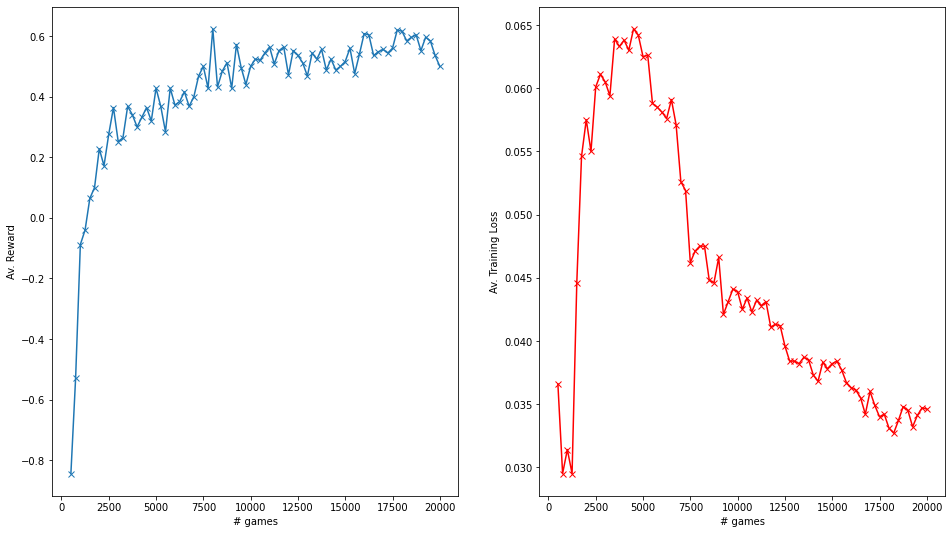

In [36]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))

ax0.plot(np.linspace(500,nb_games,79), mean_reward[1:], 'x-')
ax0.set_ylabel("Av. Reward")
ax0.set_xlabel("# games")

ax1.plot(np.linspace(500,nb_games,79), mean_loss[1:], 'x-', color = 'r')
ax1.set_ylabel("Av. Training Loss")
ax1.set_xlabel("# games")

plt.show()

# Question 12

In [37]:
# Modify batch size and initialize againg the networks
BATCH_SIZE = 1

torch.manual_seed(50)
policy_net = DQN().to(device)
target_net = DQN().to(device)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=5e-4)
memory = ReplayMemory(10000)

steps_done = 0

In [38]:
nb_games = 20000
epso = 0.

# Initialize lists for reward tracking
mean_reward = np.zeros(int(nb_games/250))
mean_loss = np.zeros(int(nb_games/250))
Reward = []
p = 0

In [39]:
episode = 0
Turns = np.array(['X','O'])
results = []
losses = []
SAVE_FREQUENCY = 500

unvalid = 0
for i in range(nb_games):
    env.reset()
    current_state,_,_ = env.observe()
    Turns = Turns[np.random.permutation(2)]

    player_opt = OptimalPlayer(epsilon=0.5, player=Turns[0])
    
    if env.current_player == player_opt.player:
        agent_is_X = False
    else:
        agent_is_X = True
    
    grid = current_state
    state_agent = get_torch_state(current_state, agent_is_X)
    state_opt = current_state
    action_opt = None
    action_agent = None
    done = False
    
    for t in count():

        if env.current_player == player_opt.player:

            action_opt = player_opt.act(state_opt)
            grid,done,winner = env.step(action_opt)

            next_state_agent = get_torch_state(grid,agent_is_X)

            
            if env.num_step > 1:
                
                if done == False:
                    reward_agent = torch.tensor([0], device=device)
                    memory.push(state_agent, action_agent, next_state_agent, reward_agent)
                    optimize_model(losses)

                else: 
                    results.append(0 if winner == None else -1)
                    reward_agent = torch.tensor([0 if winner == None else -1], device=device)
                    memory.push(state_agent, action_agent, None, reward_agent)
                    optimize_model(losses)
                    Reward.append(reward_agent.item())
                    break
 
            else:
                pass

            state_agent = next_state_agent
 

        else:

            action_agent = select_action(grid, state_agent, epso)
            valid = env.check_valid(action_agent.item())
            
            if valid:

                grid, done, winner = env.step(action_agent.item())

                if done :
                    results.append(0 if winner == None else 1)
                    reward_agent = torch.tensor([0 if winner == None else 1], device=device)
                    memory.push(state_agent, action_agent, None, reward_agent)
                    optimize_model(losses)
                    Reward.append(reward_agent.item())
                    break

                state_opt = grid

            else:
                unvalid += 1
                reward_agent = torch.tensor([-1], device=device)
                memory.push(state_agent, action_agent, None, reward_agent)
                optimize_model(losses)
                Reward.append(reward_agent.item())
                break

    if i%250 == 0:
        mean_reward[p] = np.mean(Reward)
        mean_loss[p] =round(torch.tensor(losses, device=device).mean().item(), 4)
        Reward = []
        p += 1   

    if len(results) == SAVE_FREQUENCY:
        print(i + 1, "episodes completed")
        print("unvalid =", unvalid)
        print("  Agent  |  -  |  Opt  ")
        print(
            f" {str(results.count(1)).zfill(3)} | {str(results.count(0)).zfill(3)} | {str(results.count(-1)).zfill(3)}"
        )
        print(
            "Mean loss in last",
            SAVE_FREQUENCY,
            "episodes:",
            round(torch.tensor(losses, device=device).mean().item(), 4),
        )
        print()
        checkpoint = {
            "episode": i + 1,
            "steps_done": steps_done,
            "memory": memory,
            "policy_net": policy_net.state_dict(),
            "optimizer": optimizer.state_dict(),
        }

        results = []
        losses = []
        unvalid = 0

    # Update the target networks with the policy networks every TARGET_UPDATE episodes
    if i % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

1062 episodes completed
unvalid = 562
  Agent  |  -  |  Opt  
 144 | 055 | 301
Mean loss in last 500 episodes: 0.0705

1779 episodes completed
unvalid = 217
  Agent  |  -  |  Opt  
 237 | 000 | 263
Mean loss in last 500 episodes: 0.1103

2536 episodes completed
unvalid = 257
  Agent  |  -  |  Opt  
 263 | 002 | 235
Mean loss in last 500 episodes: 0.119

3313 episodes completed
unvalid = 277
  Agent  |  -  |  Opt  
 244 | 035 | 221
Mean loss in last 500 episodes: 0.103

3933 episodes completed
unvalid = 120
  Agent  |  -  |  Opt  
 252 | 050 | 198
Mean loss in last 500 episodes: 0.1124

4635 episodes completed
unvalid = 202
  Agent  |  -  |  Opt  
 254 | 074 | 172
Mean loss in last 500 episodes: 0.1019

5237 episodes completed
unvalid = 102
  Agent  |  -  |  Opt  
 237 | 119 | 144
Mean loss in last 500 episodes: 0.0953

5819 episodes completed
unvalid = 82
  Agent  |  -  |  Opt  
 261 | 140 | 099
Mean loss in last 500 episodes: 0.0894

6392 episodes completed
unvalid = 73
  Agent  |  - 

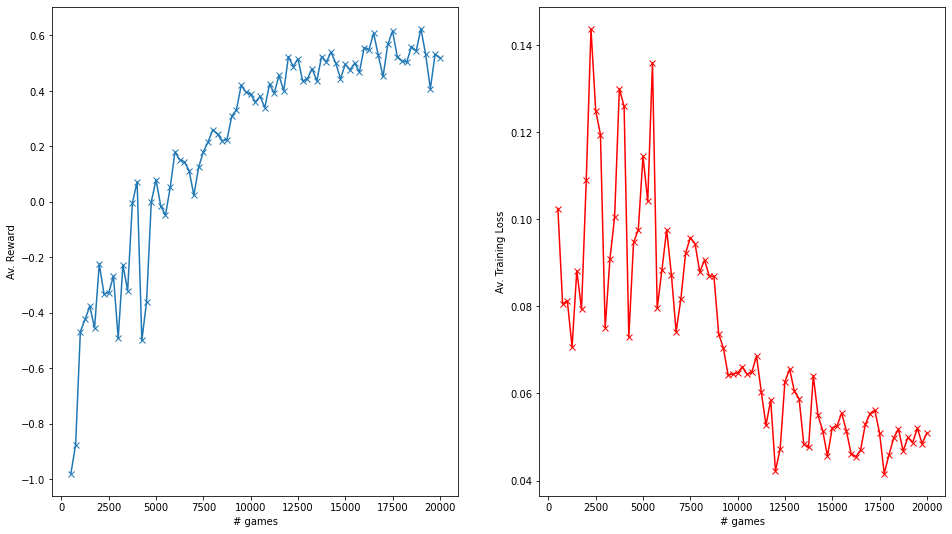

In [40]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))

ax0.plot(np.linspace(500,nb_games,79), mean_reward[1:], 'x-')
ax0.set_ylabel("Av. Reward")
ax0.set_xlabel("# games")

ax1.plot(np.linspace(500,nb_games,79), mean_loss[1:], 'x-', color = 'r')
ax1.set_ylabel("Av. Training Loss")
ax1.set_xlabel("# games")

plt.show()

# Question 13

#### Count the number of wins and looses (bottom of code commented) for a range of n_stars

In [16]:
BATCH_SIZE = 64

torch.manual_seed(50)
policy_net = DQN().to(device)
target_net = DQN().to(device)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=5e-4)
memory = ReplayMemory(10000)

steps_done = 0

In [17]:
nb_games = 20000
n_star = np.linspace(0,1,6)

# Initialize lists for reward tracking
Mopt = np.zeros((len(n_star), int(nb_games/250)))
Mrand = np.zeros((len(n_star), int(nb_games/250)))

In [18]:
episode = 0
Turns = np.array(['X','O'])
results = []
losses = []
SAVE_FREQUENCY = 500

unvalid = 0

# range over all n_stars and optimize for all of them
for n in range(len(n_star)):
    torch.manual_seed(50)
    policy_net.apply(weight_reset)
    p=0

    for i in range(nb_games):
        env.reset()
        current_state,_,_ = env.observe()
        Turns = Turns[np.random.permutation(2)]

        player_opt = OptimalPlayer(epsilon=0.5, player=Turns[0])


        eps_min = 0.1
        eps_max = 0.8

        eps_mod = max(eps_min, eps_max*(1-i/n_star[n]))

        
        if env.current_player == player_opt.player:
            agent_is_X = False
        else:
            agent_is_X = True
        
        grid = current_state
        state_agent = get_torch_state(current_state, agent_is_X)
        state_opt = current_state
        action_opt = None
        action_agent = None
        done = False
        
        for t in count():

            if env.current_player == player_opt.player:

                action_opt = player_opt.act(state_opt)
                grid,done,winner = env.step(action_opt)

                next_state_agent = get_torch_state(grid,agent_is_X)

                
                if env.num_step > 1:
                    
                    if done == False:
                        reward_agent = torch.tensor([0], device=device)
                        memory.push(state_agent, action_agent, next_state_agent, reward_agent)
                        optimize_model(losses)

                    else: 
                        results.append(0 if winner == None else -1)
                        reward_agent = torch.tensor([0 if winner == None else -1], device=device)
                        memory.push(state_agent, action_agent, None, reward_agent)
                        optimize_model(losses)
                        Reward.append(reward_agent.item())
                        break
    
                else:
                    pass

                state_agent = next_state_agent
    

            else:

                action_agent = select_action(grid, state_agent, eps_mod)
                valid = env.check_valid(action_agent.item())
                
                if valid:

                    grid, done, winner = env.step(action_agent.item())

                    if done :
                        results.append(0 if winner == None else 1)
                        reward_agent = torch.tensor([0 if winner == None else 1], device=device)
                        memory.push(state_agent, action_agent, None, reward_agent)
                        optimize_model(losses)
                        Reward.append(reward_agent.item())
                        break

                    state_opt = grid

                else:
                    unvalid += 1
                    reward_agent = torch.tensor([-1], device=device)
                    memory.push(state_agent, action_agent, None, reward_agent)
                    optimize_model(losses)
                    Reward.append(reward_agent.item())
                    break

#### ADDED HERE NEW CODE ####
# Make players only play, no optimization here. And record the number of wins and looses 
        if i%250 == 0:
            Nwin_opt = 0
            Nlos_opt = 0
            Nwin_rand = 0
            Nlos_rand = 0
            
            # for 500 games withoud optimization make our agent play against the Opt(0)
            for k in range(500):
                env.reset()
                grid, _, __ = env.observe()
                Turns = Turns[np.random.permutation(2)]
                player_opt = OptimalPlayer(epsilon=0, player=Turns[0])

                if env.current_player == player_opt.player:
                    agent_is_X = False
                else:
                    agent_is_X = True

                for j in range(9):

                    if env.current_player == player_opt.player:
                        move = player_opt.act(grid)
                        grid, end, winner = env.step(move, print_grid=False)

                    else:
                        state_agent = get_torch_state(grid, player_is_X= agent_is_X)
                        move = select_action(grid,state_agent, eps_mod)
                        valid = env.check_valid(move.item())

                        if valid:
                            grid, end, winner = env.step(move.item(), print_grid=False)
                        else:
                            winner = player_opt.player
                            end = True
                            

                    if end:
                        # if the game ends, increment the number of wins of the agent (if it wins) and the countrary otherwise
                        if winner == player_opt.player:
                            Nlos_opt += 1
                        elif winner == None:
                            pass
                        else: 
                            Nwin_opt += 1
                        break
            
            # for 500 games withoud optimization make our agent play against the Opt(1)
            for k in range(500):
                env.reset()
                grid, _, __ = env.observe()
                Turns = Turns[np.random.permutation(2)]
                player_opt = OptimalPlayer(epsilon=1, player=Turns[0])

                if env.current_player == player_opt.player:
                    agent_is_X = False
                else:
                    agent_is_X = True

                for j in range(9):

                    if env.current_player == player_opt.player:
                        move = player_opt.act(grid)
                        grid, end, winner = env.step(move, print_grid=False)

                    else:
                        state_agent = get_torch_state(grid, player_is_X= agent_is_X)
                        move = select_action(grid,state_agent, eps_mod)
                        valid = env.check_valid(move.item())

                        if valid:
                            grid, end, winner = env.step(move.item(), print_grid=False)
                        else:
                            winner = player_opt.player
                            end = True
                            

                    if end:
                        if winner == player_opt.player:
                            Nlos_rand += 1
                        elif winner == None:
                            pass
                        else: 
                            Nwin_rand += 1
                        break

            # calculate Mopt and Mrand
            Mopt[n,p] = (Nwin_opt-Nlos_opt)/500
            Mrand[n,p] = (Nwin_rand-Nlos_rand)/500
            p += 1

        if len(results) == SAVE_FREQUENCY:
            print(i + 1, "episodes completed")
            print("unvalid =", unvalid)
            print("  Agent  |  -  |  Opt  ")
            print(
                f" {str(results.count(1)).zfill(3)} | {str(results.count(0)).zfill(3)} | {str(results.count(-1)).zfill(3)}"
            )
            print(
                "Mean loss in last",
                SAVE_FREQUENCY,
                "episodes:",
                round(torch.tensor(losses, device=device).mean().item(), 4),
            )
            print()
            checkpoint = {
                "episode": i + 1,
                "steps_done": steps_done,
                "memory": memory,
                "policy_net": policy_net.state_dict(),
                "optimizer": optimizer.state_dict(),
            }

            results = []
            losses = []
            unvalid = 0

        # Update the target networks with the policy networks every TARGET_UPDATE episodes
        if i % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

/var/folders/43/k23gcw595bj9t88q4vmjsf940000gn/T/ipykernel_83881/2870804233.py:25: RuntimeWarning: invalid value encountered in double_scalars
  eps_mod = max(eps_min, eps_max*(1-i/n_star[n]))
/var/folders/43/k23gcw595bj9t88q4vmjsf940000gn/T/ipykernel_83881/2870804233.py:25: RuntimeWarning: divide by zero encountered in double_scalars
  eps_mod = max(eps_min, eps_max*(1-i/n_star[n]))


659 episodes completed
unvalid = 159
  Agent  |  -  |  Opt  
 147 | 034 | 319
Mean loss in last 500 episodes: 0.0391

1189 episodes completed
unvalid = 30
  Agent  |  -  |  Opt  
 214 | 071 | 215
Mean loss in last 500 episodes: 0.055

1702 episodes completed
unvalid = 13
  Agent  |  -  |  Opt  
 241 | 112 | 147
Mean loss in last 500 episodes: 0.0677

2211 episodes completed
unvalid = 9
  Agent  |  -  |  Opt  
 267 | 109 | 124
Mean loss in last 500 episodes: 0.0676

2721 episodes completed
unvalid = 10
  Agent  |  -  |  Opt  
 270 | 108 | 122
Mean loss in last 500 episodes: 0.0642

3235 episodes completed
unvalid = 14
  Agent  |  -  |  Opt  
 286 | 134 | 080
Mean loss in last 500 episodes: 0.0611

3751 episodes completed
unvalid = 16
  Agent  |  -  |  Opt  
 268 | 146 | 086
Mean loss in last 500 episodes: 0.0525

4258 episodes completed
unvalid = 7
  Agent  |  -  |  Opt  
 274 | 155 | 071
Mean loss in last 500 episodes: 0.051

4772 episodes completed
unvalid = 14
  Agent  |  -  |  Opt  

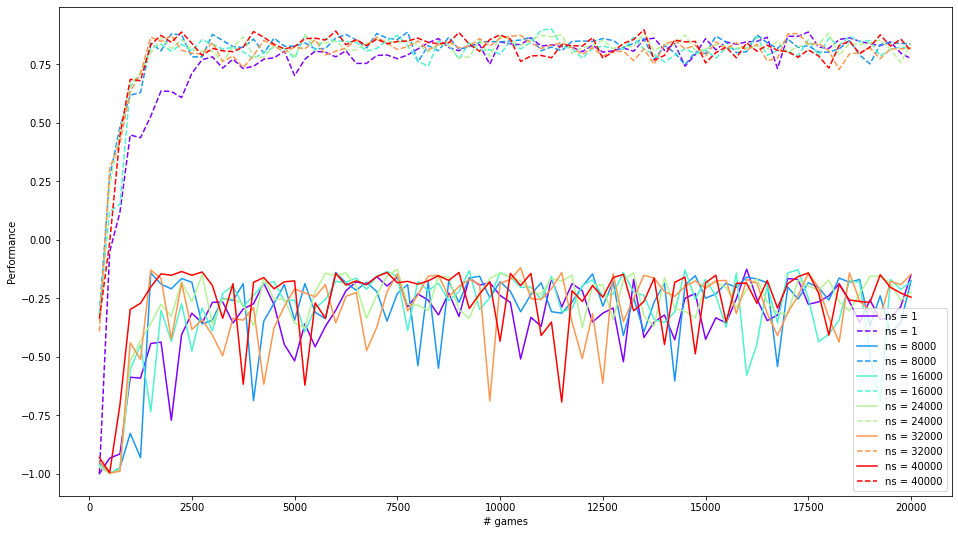

In [19]:
from matplotlib.pyplot import cm
color = iter(cm.rainbow(np.linspace(0, 1, len(n_star))))

plt.figure(figsize=(16,9))
for n in range(len(n_star)):
    c = next(color)
    plt.plot(np.linspace(250,nb_games,int(nb_games/250)), Mopt[n], '-', c=c)
    plt.plot(np.linspace(250,nb_games,int(nb_games/250)), Mrand[n], '--', c=c)
plt.legend(['ns = 1', 'ns = 1', 'ns = 8000', 'ns = 8000' , 'ns = 16000', 'ns = 16000', 'ns = 24000', 'ns = 24000', 'ns = 32000', 'ns = 32000', 'ns = 40000', 'ns = 40000'])
plt.xlabel("# games")
plt.ylabel("Performance")

plt.show()

# Question 14

#### Impact of epsilon of the optimal player

In [20]:
BATCH_SIZE = 64

torch.manual_seed(50)
policy_net = DQN().to(device)
target_net = DQN().to(device)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=5e-4)
memory = ReplayMemory(10000)

steps_done = 0

In [21]:
nb_games = 20000
epsilon_opt = np.linspace(0,1,6)
n_s = 16000

# Initialize lists for reward tracking
Mopt = np.zeros((len(epsilon_opt), int(nb_games/250)))
Mrand = np.zeros((len(epsilon_opt), int(nb_games/250)))

In [22]:
episode = 0
Turns = np.array(['X','O'])
results = []
losses = []
SAVE_FREQUENCY = 500

unvalid = 0

# range over different values of epsilon for the optimal player and optimize for all of them
for eps in range(len(epsilon_opt)):
    torch.manual_seed(50)
    policy_net.apply(weight_reset)
    p=0

    for i in range(nb_games):
        env.reset()
        current_state,_,_ = env.observe()
        Turns = Turns[np.random.permutation(2)]

        player_opt = OptimalPlayer(epsilon=epsilon_opt[eps], player=Turns[0])

        eps_min = 0.1
        eps_max = 0.8

        eps_mod = max(eps_min, eps_max*(1-i/n_s))
        
        if env.current_player == player_opt.player:
            agent_is_X = False
        else:
            agent_is_X = True
        
        grid = current_state
        state_agent = get_torch_state(current_state, agent_is_X)
        state_opt = current_state
        action_opt = None
        action_agent = None
        done = False
        
        for t in count():

            if env.current_player == player_opt.player:

                action_opt = player_opt.act(state_opt)
                grid,done,winner = env.step(action_opt)

                next_state_agent = get_torch_state(grid,agent_is_X)

                
                if env.num_step > 1:
                    
                    if done == False:
                        reward_agent = torch.tensor([0], device=device)
                        memory.push(state_agent, action_agent, next_state_agent, reward_agent)
                        optimize_model(losses)

                    else: 
                        results.append(0 if winner == None else -1)
                        reward_agent = torch.tensor([0 if winner == None else -1], device=device)
                        memory.push(state_agent, action_agent, None, reward_agent)
                        optimize_model(losses)
                        Reward.append(reward_agent.item())
                        break
    
                else:
                    pass

                state_agent = next_state_agent
    

            else:

                action_agent = select_action(grid, state_agent, eps_mod)
                valid = env.check_valid(action_agent.item())
                
                if valid:

                    grid, done, winner = env.step(action_agent.item())

                    if done :
                        results.append(0 if winner == None else 1)
                        reward_agent = torch.tensor([0 if winner == None else 1], device=device)
                        memory.push(state_agent, action_agent, None, reward_agent)
                        optimize_model(losses)
                        Reward.append(reward_agent.item())
                        break

                    state_opt = grid

                else:
                    unvalid += 1
                    reward_agent = torch.tensor([-1], device=device)
                    memory.push(state_agent, action_agent, None, reward_agent)
                    optimize_model(losses)
                    Reward.append(reward_agent.item())
                    break

        if i%250 == 0:
            Nwin_opt = 0
            Nlos_opt = 0
            Nwin_rand = 0
            Nlos_rand = 0
            
            for k in range(500):
                env.reset()
                grid, _, __ = env.observe()
                Turns = Turns[np.random.permutation(2)]
                player_opt = OptimalPlayer(epsilon=0, player=Turns[0])

                if env.current_player == player_opt.player:
                    agent_is_X = False
                else:
                    agent_is_X = True

                for j in range(9):

                    if env.current_player == player_opt.player:
                        move = player_opt.act(grid)
                        grid, end, winner = env.step(move, print_grid=False)

                    else:
                        state_agent = get_torch_state(grid, player_is_X= agent_is_X)
                        move = select_action(grid,state_agent, eps_mod)
                        valid = env.check_valid(move.item())

                        if valid:
                            grid, end, winner = env.step(move.item(), print_grid=False)
                        else:
                            winner = player_opt.player
                            end = True
                            

                    if end:
                        if winner == player_opt.player:
                            Nlos_opt += 1
                        elif winner == None:
                            pass
                        else: 
                            Nwin_opt += 1
                        break
            
            for k in range(500):
                env.reset()
                grid, _, __ = env.observe()
                Turns = Turns[np.random.permutation(2)]
                player_opt = OptimalPlayer(epsilon=1, player=Turns[0])

                if env.current_player == player_opt.player:
                    agent_is_X = False
                else:
                    agent_is_X = True

                for j in range(9):

                    if env.current_player == player_opt.player:
                        move = player_opt.act(grid)
                        grid, end, winner = env.step(move, print_grid=False)

                    else:
                        state_agent = get_torch_state(grid, player_is_X= agent_is_X)
                        move = select_action(grid,state_agent, eps_mod)
                        valid = env.check_valid(move.item())

                        if valid:
                            grid, end, winner = env.step(move.item(), print_grid=False)
                        else:
                            winner = player_opt.player
                            end = True
                            

                    if end:
                        if winner == player_opt.player:
                            Nlos_rand += 1
                        elif winner == None:
                            pass
                        else: 
                            Nwin_rand += 1
                        break

            Mopt[eps,p] = (Nwin_opt-Nlos_opt)/500
            Mrand[eps,p] = (Nwin_rand-Nlos_rand)/500
            p += 1

        if len(results) == SAVE_FREQUENCY:
            print(i + 1, "episodes completed")
            print("unvalid =", unvalid)
            print("  Agent  |  -  |  Opt  ")
            print(
                f" {str(results.count(1)).zfill(3)} | {str(results.count(0)).zfill(3)} | {str(results.count(-1)).zfill(3)}"
            )
            print(
                "Mean loss in last",
                SAVE_FREQUENCY,
                "episodes:",
                round(torch.tensor(losses, device=device).mean().item(), 4),
            )
            print()
            checkpoint = {
                "episode": i + 1,
                "steps_done": steps_done,
                "memory": memory,
                "policy_net": policy_net.state_dict(),
                "optimizer": optimizer.state_dict(),
            }

            results = []
            losses = []
            unvalid = 0

        # Update the target networks with the policy networks every TARGET_UPDATE episodes
        if i % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

539 episodes completed
unvalid = 39
  Agent  |  -  |  Opt  
 000 | 054 | 446
Mean loss in last 500 episodes: 0.0156

1048 episodes completed
unvalid = 9
  Agent  |  -  |  Opt  
 000 | 103 | 397
Mean loss in last 500 episodes: 0.0036

1562 episodes completed
unvalid = 14
  Agent  |  -  |  Opt  
 000 | 110 | 390
Mean loss in last 500 episodes: 0.0025

2075 episodes completed
unvalid = 13
  Agent  |  -  |  Opt  
 000 | 104 | 396
Mean loss in last 500 episodes: 0.001

2587 episodes completed
unvalid = 12
  Agent  |  -  |  Opt  
 000 | 135 | 365
Mean loss in last 500 episodes: 0.001

3091 episodes completed
unvalid = 4
  Agent  |  -  |  Opt  
 000 | 137 | 363
Mean loss in last 500 episodes: 0.0007

3597 episodes completed
unvalid = 6
  Agent  |  -  |  Opt  
 000 | 138 | 362
Mean loss in last 500 episodes: 0.0006

4102 episodes completed
unvalid = 5
  Agent  |  -  |  Opt  
 000 | 159 | 341
Mean loss in last 500 episodes: 0.0003

4605 episodes completed
unvalid = 3
  Agent  |  -  |  Opt  
 00

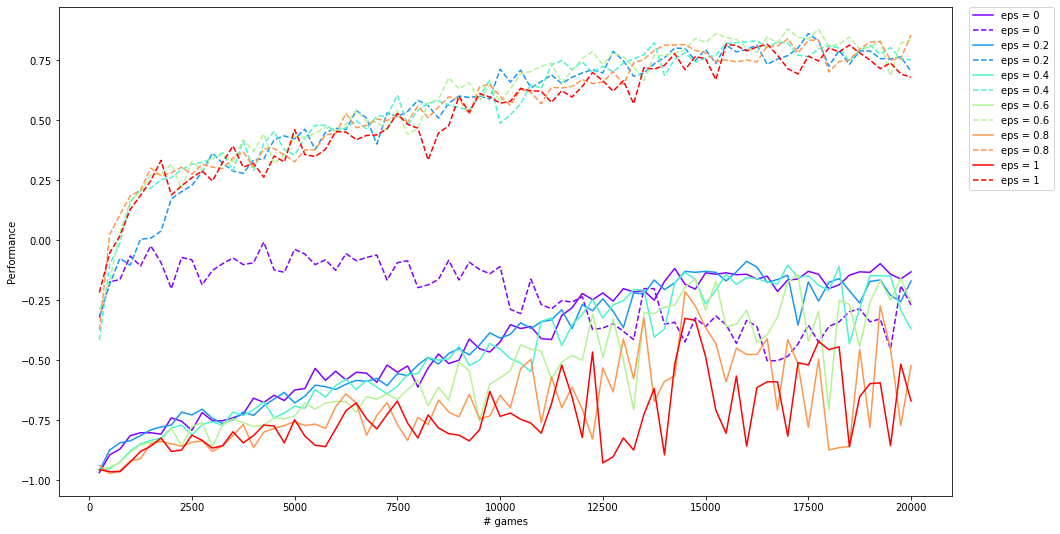

In [23]:
from matplotlib.pyplot import cm
color = iter(cm.rainbow(np.linspace(0, 1, len(epsilon_opt))))

plt.figure(figsize=(16,9))
for n in range(len(epsilon_opt)):
    c = next(color)
    plt.plot(np.linspace(250,nb_games,int(nb_games/250)), Mopt[n], '-', c=c)
    plt.plot(np.linspace(250,nb_games,int(nb_games/250)), Mrand[n], '--', c=c)
plt.legend(['eps = 0', 'eps = 0', 'eps = 0.2', 'eps = 0.2', 'eps = 0.4', 'eps = 0.4', 'eps = 0.6', 'eps = 0.6', 'eps = 0.8', 'eps = 0.8', 'eps = 1', 'eps = 1'], bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel("# games")
plt.ylabel("Performance")

plt.show()

# Question 15

In [24]:
max_Mopt = np.max(Mopt)
print("max_Mopt = ", max_Mopt)
max_Mrand = np.max(Mrand)
print('max_Mrand = ',max_Mrand)

max_Mopt =  -0.088
max_Mrand =  0.88


# Self-learning

# Question 16

In [25]:
nb_games = 20000
epsilon_agent = np.linspace(0,1,6)

# Initialize lists for reward tracking
Mopt = np.zeros((len(epsilon_agent), int(nb_games/250)))
Mrand = np.zeros((len(epsilon_agent), int(nb_games/250)))

In [26]:
episode = 0
Turns = np.array(['X','O'])
results = []
losses = []
SAVE_FREQUENCY = 500

unvalid = 0
for eps in range(len(epsilon_agent)):
    torch.manual_seed(50)
    policy_net.apply(weight_reset)
    p=0
    for i in range(nb_games):
        # Initialize the environment and state
        env.reset()
        grid,done,_ = env.observe()
        state_x = get_torch_state(grid, True)
        state_o = get_torch_state(grid, False)
        action_x = None
        action_o = None
        done = False

        for t in count():
        
            if env.current_player == 'X':
                # Play as X
                action_x = select_action(grid,state_x, epsilon_agent[eps])
                valid = env.check_valid(action_x.item())


                if valid:
                    grid, done, winner = env.step(action_x.item())
                    next_state_o = get_torch_state(grid, False)

                    if done :
                        # if the game ends the reward for x is a tie or a win (1)
                        # and the reward for o is a tie or a lose (-1)
                        # optimize for both
                        results.append(0 if winner == None else 1)
                        reward_x = torch.tensor([0 if winner == None else 1], device=device)
                        reward_o = torch.tensor([0 if winner == None else -1], device=device)
                        memory.push(state_x, action_x, None, reward_x)
                        memory.push(state_o, action_o, None, reward_o)
                        optimize_model(losses)
                        break

                    state_o = next_state_o

                else:
                    # if move is invalid reward is -1 and optimize 
                    unvalid += 1
                    reward_x = torch.tensor([-1], device=device)
                    memory.push(state_x, action_x, None, reward_x)
                    optimize_model(losses)
                    break
        
            else:
                # Play as O
                action_o = select_action(grid,state_o, epsilon_agent[eps])
                valid = env.check_valid(action_o.item())



                if valid:
                    grid, done, winner = env.step(action_o.item())
                    next_state_x = get_torch_state(grid, True)


                    if done :
                        # if the game ends the reward for x is a tie or a lose (-1)
                        # and the reward for o is a tie or a lose (1)
                        # optimize for both
                        results.append(0 if winner == None else -1)
                        reward_o = torch.tensor([0 if winner == None else 1], device=device)
                        reward_x = torch.tensor([0 if winner == None else -1], device=device)
                        memory.push(state_o, action_o, None, reward_o)
                        memory.push(state_x, action_x, None, reward_x)
                        optimize_model(losses)
                        break

                    state_x = next_state_x

                else:
                    # if move is invalid reward is -1 and optimize 
                    unvalid += 1
                    reward_o = torch.tensor([-1], device=device)
                    memory.push(state_o, action_o, None, reward_o)
                    optimize_model(losses)
                    break

        # count and record the wins and lose for Mopt and Mrand (without optimizing)
        if i%250 == 0:
            Nwin_opt = 0
            Nlos_opt = 0
            Nwin_rand = 0
            Nlos_rand = 0
            
            for k in range(500):
                env.reset()
                grid, _, __ = env.observe()
                Turns = Turns[np.random.permutation(2)]
                player_opt = OptimalPlayer(epsilon=0, player=Turns[0])

                if env.current_player == player_opt.player:
                    agent_is_X = False
                else:
                    agent_is_X = True

                for j in range(9):

                    if env.current_player == player_opt.player:
                        move = player_opt.act(grid)
                        grid, end, winner = env.step(move, print_grid=False)

                    else:
                        state_agent = get_torch_state(grid, player_is_X= agent_is_X)
                        move = select_action(grid,state_agent, epsilon_agent[eps])
                        valid = env.check_valid(move.item())

                        if valid:
                            grid, end, winner = env.step(move.item(), print_grid=False)
                        else:
                            winner = player_opt.player
                            end = True
                            

                    if end:
                        if winner == player_opt.player:
                            Nlos_opt += 1
                        elif winner == None:
                            pass
                        else: 
                            Nwin_opt += 1
                        break
            
            for k in range(500):
                env.reset()
                grid, _, __ = env.observe()
                Turns = Turns[np.random.permutation(2)]
                player_opt = OptimalPlayer(epsilon=1, player=Turns[0])

                if env.current_player == player_opt.player:
                    agent_is_X = False
                else:
                    agent_is_X = True

                for j in range(9):

                    if env.current_player == player_opt.player:
                        move = player_opt.act(grid)
                        grid, end, winner = env.step(move, print_grid=False)

                    else:
                        state_agent = get_torch_state(grid, player_is_X= agent_is_X)
                        move = select_action(grid,state_agent, epsilon_agent[eps])
                        valid = env.check_valid(move.item())

                        if valid:
                            grid, end, winner = env.step(move.item(), print_grid=False)
                        else:
                            winner = player_opt.player
                            end = True
                            

                    if end:
                        if winner == player_opt.player:
                            Nlos_rand += 1
                        elif winner == None:
                            pass
                        else: 
                            Nwin_rand += 1
                        break

            Mopt[eps,p] = (Nwin_opt-Nlos_opt)/500
            Mrand[eps,p] = (Nwin_rand-Nlos_rand)/500
            p += 1

        if len(results) == SAVE_FREQUENCY:
            print("unvalid =", unvalid)
            print(i + 1, "episodes completed")
            # print(f"{time.thread_time() - start_time} seconds")
            print("  X  |  -  |  O  ")
            print(
                f" {str(results.count(1)).zfill(3)} | {str(results.count(0)).zfill(3)} | {str(results.count(-1)).zfill(3)}"
            )
            print(
                "Mean loss in last",
                SAVE_FREQUENCY,
                "episodes:",
                round(torch.tensor(losses, device=device).mean().item(), 4),
            )
            print()
            checkpoint = {
                "episode": i + 1,
                "steps_done": steps_done,
                "memory": memory,
                "policy_net": policy_net.state_dict(),
                "optimizer": optimizer.state_dict(),
            }

            results = []
            losses = []
            unvalid = 0

        # Update the target networks with the policy networks every TARGET_UPDATE episodes
        if i % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

unvalid = 595
1095 episodes completed
  X  |  -  |  O  
 407 | 000 | 093
Mean loss in last 500 episodes: 0.0705

unvalid = 141
1736 episodes completed
  X  |  -  |  O  
 251 | 032 | 217
Mean loss in last 500 episodes: 0.0677

unvalid = 110
2346 episodes completed
  X  |  -  |  O  
 183 | 112 | 205
Mean loss in last 500 episodes: 0.0575

unvalid = 102
2948 episodes completed
  X  |  -  |  O  
 129 | 151 | 220
Mean loss in last 500 episodes: 0.0455

unvalid = 12
3460 episodes completed
  X  |  -  |  O  
 249 | 213 | 038
Mean loss in last 500 episodes: 0.0342

unvalid = 17
3977 episodes completed
  X  |  -  |  O  
 216 | 250 | 034
Mean loss in last 500 episodes: 0.0256

unvalid = 6
4483 episodes completed
  X  |  -  |  O  
 129 | 366 | 005
Mean loss in last 500 episodes: 0.0209

unvalid = 7
4990 episodes completed
  X  |  -  |  O  
 019 | 481 | 000
Mean loss in last 500 episodes: 0.0098

unvalid = 131
5621 episodes completed
  X  |  -  |  O  
 372 | 128 | 000
Mean loss in last 500 episode

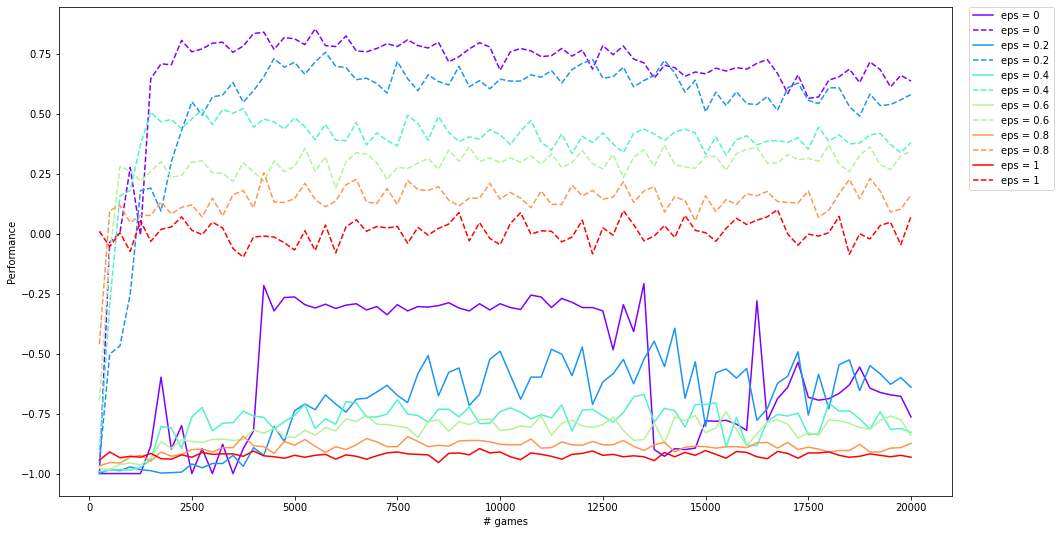

In [27]:
from matplotlib.pyplot import cm
color = iter(cm.rainbow(np.linspace(0, 1, len(epsilon_agent))))

plt.figure(figsize=(16,9))
for n in range(len(epsilon_agent)):
    c = next(color)
    plt.plot(np.linspace(250,nb_games,int(nb_games/250)), Mopt[n], '-', c=c)
    plt.plot(np.linspace(250,nb_games,int(nb_games/250)), Mrand[n], '--', c=c)
plt.legend(['eps = 0', 'eps = 0', 'eps = 0.2', 'eps = 0.2', 'eps = 0.4', 'eps = 0.4', 'eps = 0.6', 'eps = 0.6', 'eps = 0.8', 'eps = 0.8', 'eps = 1', 'eps = 1'], bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel("# games")
plt.ylabel("Performance")
# plt.title("Mopt [-] and Mrand [--] for different values of eps")
plt.show()

# Question 17

In [28]:
nb_games = 20000
n_star = np.linspace(1,40000,6)

# Initialize lists for reward tracking
Mopt = np.zeros((len(n_star), int(nb_games/250)))
Mrand = np.zeros((len(n_star), int(nb_games/250)))

In [29]:
episode = 0
Turns = np.array(['X','O'])
results = []
losses = []
SAVE_FREQUENCY = 500

unvalid = 0
for n in range(len(n_star)):
    torch.manual_seed(50)
    policy_net.apply(weight_reset)
    p=0
    for i in range(nb_games):
        # Initialize the environment and state
        env.reset()
        grid,done,_ = env.observe()
        state_x = get_torch_state(grid, True)
        state_o = get_torch_state(grid, False)
        action_x = None
        action_o = None
        done = False
        
        eps_min = 0.1
        eps_max = 0.8

        eps_mod = max(eps_min, eps_max*(1-i/n_star[n]))
        

        for t in count():

            if env.current_player == 'X':
                # Play as X
                action_x = select_action(grid,state_x, eps_mod)
                valid = env.check_valid(action_x.item())

                if valid:
                    grid, done, winner = env.step(action_x.item())
                    next_state_o = get_torch_state(grid, False)

                    if done :
                        results.append(0 if winner == None else 1)
                        reward_x = torch.tensor([0 if winner == None else 1], device=device)
                        reward_o = torch.tensor([0 if winner == None else -1], device=device)
                        memory.push(state_x, action_x, None, reward_x)
                        memory.push(state_o, action_o, None, reward_o)
                        optimize_model(losses)
                        break

                    state_o = next_state_o

                else:
                    unvalid += 1
                    reward_x = torch.tensor([-1], device=device)
                    memory.push(state_x, action_x, None, reward_x)
                    optimize_model(losses)
                    break
        
            else:
                # Play as O
                action_o = select_action(grid,state_o, eps_mod)
                valid = env.check_valid(action_o.item())

                if valid:
                    grid, done, winner = env.step(action_o.item())
                    next_state_x = get_torch_state(grid, True)


                    if done :
                        results.append(0 if winner == None else -1)
                        reward_o = torch.tensor([0 if winner == None else 1], device=device)
                        reward_x = torch.tensor([0 if winner == None else -1], device=device)
                        memory.push(state_o, action_o, None, reward_o)
                        memory.push(state_x, action_x, None, reward_x)
                        optimize_model(losses)
                        break

                    state_x = next_state_x

                else:
                    unvalid += 1
                    reward_o = torch.tensor([-1], device=device)
                    memory.push(state_o, action_o, None, reward_o)
                    optimize_model(losses)
                    break

        if i%250 == 0:
            Nwin_opt = 0
            Nlos_opt = 0
            Nwin_rand = 0
            Nlos_rand = 0
            
            for k in range(500):
                env.reset()
                grid, _, __ = env.observe()
                Turns = Turns[np.random.permutation(2)]
                player_opt = OptimalPlayer(epsilon=0, player=Turns[0])

                if env.current_player == player_opt.player:
                    agent_is_X = False
                else:
                    agent_is_X = True

                for j in range(9):

                    if env.current_player == player_opt.player:
                        move = player_opt.act(grid)
                        grid, end, winner = env.step(move, print_grid=False)

                    else:
                        state_agent = get_torch_state(grid, player_is_X= agent_is_X)
                        move = select_action(grid,state_agent, eps_mod)
                        valid = env.check_valid(move.item())

                        if valid:
                            grid, end, winner = env.step(move.item(), print_grid=False)
                        else:
                            winner = player_opt.player
                            end = True
                            

                    if end:
                        if winner == player_opt.player:
                            Nlos_opt += 1
                        elif winner == None:
                            pass
                        else: 
                            Nwin_opt += 1
                        break
            
            for k in range(500):
                env.reset()
                grid, _, __ = env.observe()
                Turns = Turns[np.random.permutation(2)]
                player_opt = OptimalPlayer(epsilon=1, player=Turns[0])

                if env.current_player == player_opt.player:
                    agent_is_X = False
                else:
                    agent_is_X = True

                for j in range(9):

                    if env.current_player == player_opt.player:
                        move = player_opt.act(grid)
                        grid, end, winner = env.step(move, print_grid=False)

                    else:
                        state_agent = get_torch_state(grid, player_is_X= agent_is_X)
                        move = select_action(grid,state_agent, eps_mod)
                        valid = env.check_valid(move.item())

                        if valid:
                            grid, end, winner = env.step(move.item(), print_grid=False)
                        else:
                            winner = player_opt.player
                            end = True
                            
                    if end:
                        if winner == player_opt.player:
                            Nlos_rand += 1
                        elif winner == None:
                            pass
                        else: 
                            Nwin_rand += 1
                        break

            Mopt[n,p] = (Nwin_opt-Nlos_opt)/500
            Mrand[n,p] = (Nwin_rand-Nlos_rand)/500
            p += 1

        if len(results) == SAVE_FREQUENCY:
            print("unvalid =", unvalid)
            print(i + 1, "episodes completed")
            # print(f"{time.thread_time() - start_time} seconds")
            print("  X  |  -  |  O  ")
            print(
                f" {str(results.count(1)).zfill(3)} | {str(results.count(0)).zfill(3)} | {str(results.count(-1)).zfill(3)}"
            )
            print(
                "Mean loss in last",
                SAVE_FREQUENCY,
                "episodes:",
                round(torch.tensor(losses, device=device).mean().item(), 4),
            )
            print()
            checkpoint = {
                "episode": i + 1,
                "steps_done": steps_done,
                "memory": memory,
                "policy_net": policy_net.state_dict(),
                "optimizer": optimizer.state_dict(),
            }

            results = []
            losses = []
            unvalid = 0

        # Update the target networks with the policy networks every TARGET_UPDATE episodes
        if i % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

unvalid = 1877
2377 episodes completed
  X  |  -  |  O  
 458 | 000 | 042
Mean loss in last 500 episodes: 0.0415

unvalid = 234
3111 episodes completed
  X  |  -  |  O  
 455 | 001 | 044
Mean loss in last 500 episodes: 0.0075

unvalid = 148
3759 episodes completed
  X  |  -  |  O  
 464 | 004 | 032
Mean loss in last 500 episodes: 0.0056

unvalid = 153
4412 episodes completed
  X  |  -  |  O  
 205 | 259 | 036
Mean loss in last 500 episodes: 0.0057

unvalid = 176
5088 episodes completed
  X  |  -  |  O  
 104 | 359 | 037
Mean loss in last 500 episodes: 0.0032

unvalid = 48
5636 episodes completed
  X  |  -  |  O  
 108 | 370 | 022
Mean loss in last 500 episodes: 0.0019

unvalid = 64
6200 episodes completed
  X  |  -  |  O  
 121 | 357 | 022
Mean loss in last 500 episodes: 0.0011

unvalid = 130
6830 episodes completed
  X  |  -  |  O  
 255 | 204 | 041
Mean loss in last 500 episodes: 0.0007

unvalid = 118
7448 episodes completed
  X  |  -  |  O  
 404 | 045 | 051
Mean loss in last 500 ep

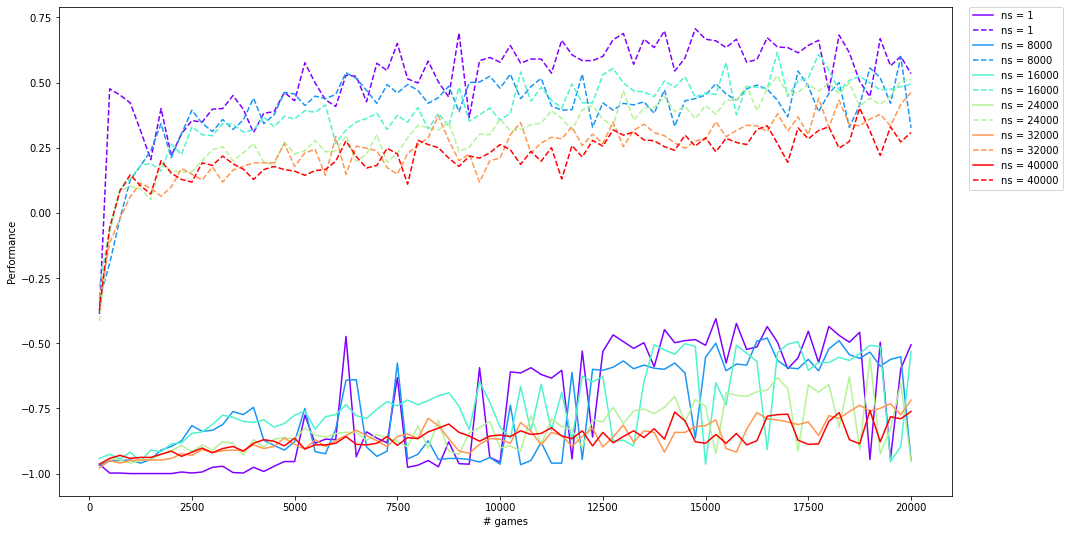

In [31]:
from matplotlib.pyplot import cm
color = iter(cm.rainbow(np.linspace(0, 1, len(n_star))))

plt.figure(figsize=(16,9))
for n in range(len(n_star)):
    c=next(color)
    plt.plot(np.linspace(250,nb_games,80), Mopt[n], '-', c=c)
    plt.plot(np.linspace(250,nb_games,80), Mrand[n], '--', c=c)
plt.legend(['ns = 1', 'ns = 1', 'ns = 8000', 'ns = 8000' , 'ns = 16000', 'ns = 16000', 'ns = 24000', 'ns = 24000', 'ns = 32000', 'ns = 32000', 'ns = 40000', 'ns = 40000'], bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel("# games")
plt.ylabel("Performance")
# plt.title("Mopt [-] and Mrand [--] for different values of n*")
plt.show()

# Question 18

In [32]:
max_Mopt = np.max(Mopt)
print("max_Mopt = ", max_Mopt)
max_Mrand = np.max(Mrand)
print('max_Mrand = ',max_Mrand)

max_Mopt =  -0.406
max_Mrand =  0.706


# Question 19

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[ 1.  0.  0.]
 [ 1. -1.  0.]
 [-1.  0.  0.]]
[[ 1.  0.  1.]
 [ 1. -1.  0.]
 [-1.  0. -1.]]
|- - -|
|- - -|
|- - -|

|X - -|
|X O -|
|O - -|

|X - X|
|X O -|
|O - O|

unvalid = 723
1223 episodes completed
  X  |  -  |  O  
 411 | 000 | 089
Mean loss in last 500 episodes: 0.0292

unvalid = 282
2005 episodes completed
  X  |  -  |  O  
 399 | 001 | 100
Mean loss in last 500 episodes: 0.007

unvalid = 216
2721 episodes completed
  X  |  -  |  O  
 415 | 000 | 085
Mean loss in last 500 episodes: 0.0036

unvalid = 119
3340 episodes completed
  X  |  -  |  O  
 440 | 006 | 054
Mean loss in last 500 episodes: 0.0034

unvalid = 155
3995 episodes completed
  X  |  -  |  O  
 454 | 000 | 046
Mean loss in last 500 episodes: 0.0024

unvalid = 123
4618 episodes completed
  X  |  -  |  O  
 450 | 000 | 050
Mean loss in last 500 episodes: 0.0027

unvalid = 189
5307 episodes completed
  X  |  -  |  O  
 422 | 002 | 076
Mean loss in last 500 episodes: 0.0039

unvali

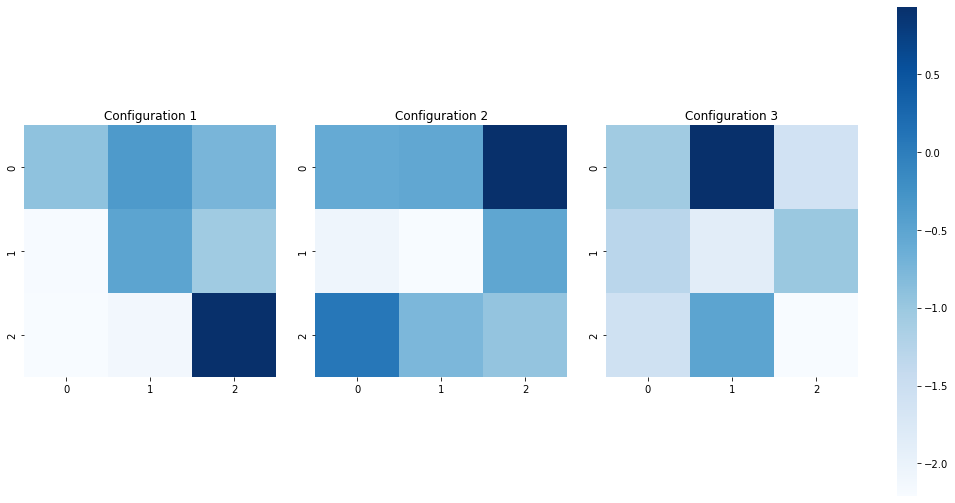

In [42]:
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 500

torch.manual_seed(50)
policy_net = DQN().to(device)
target_net = DQN().to(device)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=5e-4)
memory = ReplayMemory(10000)


steps_done = 0




import seaborn as sns

# initialize the three states
state_s1 = np.array([[0,0,0],[0,0,0],[0,0,0]], dtype="float64")
state_s2 = np.array([[1,0,0],[1,-1,0],[-1,0,0]], dtype="float64")
state_s3 = np.array([[1,0,1],[1,-1,0],[-1,0,-1]], dtype="float64")

print(state_s1)
print(state_s2)
print(state_s3)

value2player = {0: '-', 1: 'X', -1: 'O'}
for i in range(3):
    print('|', end='')
    for j in range(3):
        print(value2player[int(state_s1[i,j])], end=' ' if j<2 else '')
    print('|')
print()

value2player = {0: '-', 1: 'X', -1: 'O'}
for i in range(3):
    print('|', end='')
    for j in range(3):
        print(value2player[int(state_s2[i,j])], end=' ' if j<2 else '')
    print('|')
print()

value2player = {0: '-', 1: 'X', -1: 'O'}
for i in range(3):
    print('|', end='')
    for j in range(3):
        print(value2player[int(state_s3[i,j])], end=' ' if j<2 else '')
    print('|')
print()


episode = 0

Turns = np.array(['X','O'])
results = []
losses = []
SAVE_FREQUENCY = 500
nb_games = 20000

unvalid = 0

n_s = 1

torch.manual_seed(50)
policy_net.apply(weight_reset)
p=0

# train
for i in range(nb_games):
    # Initialize the environment and state
    env.reset()
    grid,done,_ = env.observe()
    state_x = get_torch_state(grid, True)
    state_o = get_torch_state(grid, False)
    action_x = None
    action_o = None
    done = False

    eps_min = 0.1
    eps_max = 0.8

    eps_mod = max(eps_min, eps_max*(1-i/n_s))

    for t in count():

        if env.current_player == 'X':
            # Play as X
            action_x = select_action(grid,state_x, eps_mod)
            valid = env.check_valid(action_x.item())


            if valid:
                grid, done, winner = env.step(action_x.item())
                next_state_o = get_torch_state(grid, False)

                if done :
                    results.append(0 if winner == None else 1)
                    reward_x = torch.tensor([0 if winner == None else 1], device=device)
                    reward_o = torch.tensor([0 if winner == None else -1], device=device)
                    memory.push(state_x, action_x, None, reward_x)
                    memory.push(state_o, action_o, None, reward_o)
                    optimize_model(losses)
                    break

                state_o = next_state_o

            else:

                unvalid += 1
                reward_x = torch.tensor([-1], device=device)
                memory.push(state_x, action_x, None, reward_x)
                optimize_model(losses)
                break

        else:
            # Play as O
            action_o = select_action(grid,state_o, eps_mod)
            valid = env.check_valid(action_o.item())

            if valid:
                grid, done, winner = env.step(action_o.item())
                next_state_x = get_torch_state(grid, True)


                if done :
                    results.append(0 if winner == None else -1)
                    reward_o = torch.tensor([0 if winner == None else 1], device=device)
                    reward_x = torch.tensor([0 if winner == None else -1], device=device)
                    memory.push(state_o, action_o, None, reward_o)
                    memory.push(state_x, action_x, None, reward_x)
                    optimize_model(losses)
                    break

                state_x = next_state_x

            else:
                unvalid += 1
                reward_o = torch.tensor([-1], device=device)
                memory.push(state_o, action_o, None, reward_o)
                optimize_model(losses)
                break

    if len(results) == SAVE_FREQUENCY:
        print("unvalid =", unvalid)
        print(i + 1, "episodes completed")
        # print(f"{time.thread_time() - start_time} seconds")
        print("  X  |  -  |  O  ")
        print(
            f" {str(results.count(1)).zfill(3)} | {str(results.count(0)).zfill(3)} | {str(results.count(-1)).zfill(3)}"
        )
        print(
            "Mean loss in last",
            SAVE_FREQUENCY,
            "episodes:",
            round(torch.tensor(losses, device=device).mean().item(), 4),
        )
        print()
        checkpoint = {
            "episode": i + 1,
            "steps_done": steps_done,
            "memory": memory,
            "policy_net": policy_net.state_dict(),
            "optimizer": optimizer.state_dict(),
        }

        results = []
        losses = []
        unvalid = 0

    # Update the target networks with the policy networks every TARGET_UPDATE episodes
    if i % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())




def Q_heat(state_s):
    s = policy_net(get_torch_state(state_s, True)).view(3,3)
    print(s.size())
    return s

# make network play and output Q
state_heat_1 = Q_heat(state_s1)

state_heat_2 = Q_heat(state_s2)

state_heat_3 = Q_heat(state_s3)

# Plot
fig, (ax0, ax1, ax2, axcb) = plt.subplots(nrows=1, ncols=4, figsize=(16, 9), gridspec_kw={'width_ratios':[1,1,1,0.08]})

ax0 = sns.heatmap(state_heat_1.detach().numpy(), cmap = "Blues", square=True, cbar=False, ax=ax0)
ax0.set_title("Configuration 1")
ax0.set_xlabel("")

ax1 = sns.heatmap(state_heat_2.detach().numpy(), cmap = "Blues", square=True, cbar=False, ax=ax1)
ax1.set_title("Configuration 2")

ax2 = sns.heatmap(state_heat_3.detach().numpy(), cmap = "Blues", square=True, ax=ax2, cbar_ax=axcb)
ax2.set_title("Configuration 3")

# fig.suptitle('Heatmap for three states')
plt.show()